# Predicting Housing Prices in Ames, Iowa

Predict home sale prices in Ames, Iowa using predictors including size of the house, location, and year built. There are 80 features and 2919 samples total in the dataset.

In [1]:
import math
import matplotlib
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from IPython.display import HTML, display
from mpl_toolkits.mplot3d import Axes3D
from prettytable import PrettyTable 
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier as RDFC
from sklearn.ensemble import RandomForestRegressor as RDFR
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from statsmodels.regression.linear_model import OLS

%matplotlib inline

Import data:

In [2]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
id_test = df_test.Id
print('Training dimension: {}\nTest dimension: {}'.format(df.shape, df_test.shape))
display(HTML(df.head().to_html(index=False)))

Training dimension: (1460, 81)
Test dimension: (1459, 80)


Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Target variable: `SalePrice`

We first remove outliers in the target variable as they clearly don't contribute to the predictive power of the model.

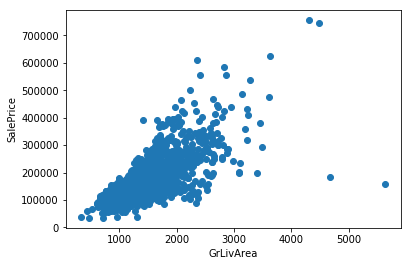

In [3]:
fig, ax = plt.subplots()
ax.scatter(x=df['GrLivArea'], y=df['SalePrice'])
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

df = df.drop(df[(df['GrLivArea'] > 4000) & (df['SalePrice'] < 300000)].index)
train_count = df.shape[0]

Target variable distribution is right-skewed. Perform log transformation to make it normal.

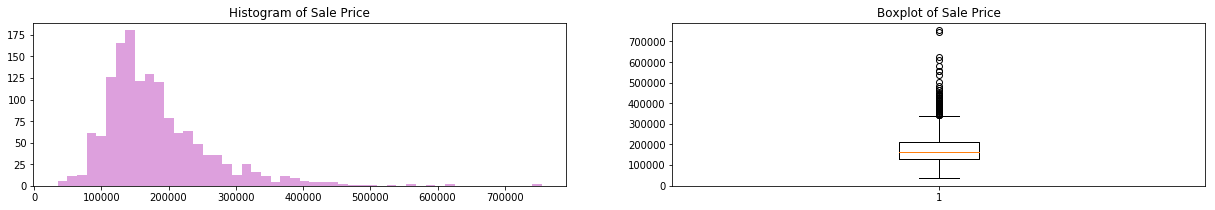

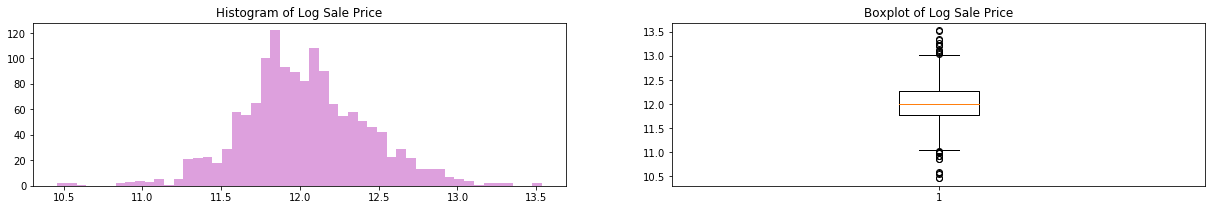

In [4]:
# Plot target variable distribution 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 3))
ax1.hist(df['SalePrice'], bins=50, color='plum')
ax1.set_title('Histogram of Sale Price')
ax2.boxplot(df['SalePrice'])
ax2.set_title('Boxplot of Sale Price')
plt.show()

# Log transformation of target variable 
logprice = df['SalePrice'].apply(lambda x: math.log(x))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 3))
ax1.hist(logprice, bins=50, color='plum')
ax1.set_title('Histogram of Log Sale Price')
ax2.boxplot(logprice)
ax2.set_title('Boxplot of Log Sale Price')
plt.show()

## Predictors

Let's take a look at the features.

In [5]:
# Identify numerical and categorical features
numeric = df.select_dtypes(include = ['float64', 'int64']).iloc[:, 1:37]
categorical = df.select_dtypes(include = ['object'])
categorical_full = pd.concat([categorical, df[['MSSubClass', 'OverallQual', 'OverallCond']]])
print('Numeric features: {}\nCategorical features: {}'.format(numeric.shape[1], categorical_full.shape[1]))

Numeric features: 36
Categorical features: 46


The features can be further broken down into 4 categories:

In [6]:
continous_col = [
    'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
    '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
    'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
]
discrete_col = [
    'YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
    'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'MoSold', 'YrSold',
]
ordinal_col = [
    'Utilities', 'LandSlope', 'HouseStyle', 'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond',
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'Electrical',
    'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
    'PoolQC', 'Fence',
]
nominal_col = [
    'MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood',
    'Condition1', 'Condition2', 'BldgType', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
    'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'GarageType', 'MiscFeature', 'SaleType',
    'SaleCondition',
]

t = PrettyTable()
t.add_column('Continuous Numerical', np.concatenate([continous_col, np.repeat([''], 4)]))
t.add_column('Discrete Numerical', np.concatenate([discrete_col, np.repeat([''], 9)]))
t.add_column('Ordinal Categorical', ordinal_col)
t.add_column('Nominal Categorial', nominal_col)
display(HTML(t.get_html_string()))

Continuous Numerical,Discrete Numerical,Ordinal Categorical,Nominal Categorial
LotFrontage,YearBuilt,Utilities,MSSubClass
LotArea,YearRemodAdd,LandSlope,MSZoning
MasVnrArea,BsmtFullBath,HouseStyle,Street
BsmtFinSF1,BsmtHalfBath,OverallQual,Alley
BsmtFinSF2,FullBath,OverallCond,LotShape
BsmtUnfSF,HalfBath,ExterQual,LandContour
TotalBsmtSF,BedroomAbvGr,ExterCond,LotConfig
1stFlrSF,KitchenAbvGr,BsmtQual,Neighborhood
2ndFlrSF,TotRmsAbvGrd,BsmtCond,Condition1
LowQualFinSF,Fireplaces,BsmtExposure,Condition2


## Missing-Data Imputation

To impute missing data, first combine training and test sets so that they can be processed together.

In [7]:
df_all = pd.concat([df[df.columns[:-1]], df_test])

### A. Numerical Features
In the training data set, there are 3 predictors with missing values: `LotFrontage`, `MasVnrArea` and `GarageYrBlt`.
In the test data set, there are 11 predictors with missing values. Many of them are from one single observation.

In [8]:
# Training dataset
n_missing = [numeric[col].isnull().values.sum() for col in numeric]
missing = pd.DataFrame({'Features': numeric.columns.values, 'Missing': n_missing})
display(HTML(missing[missing['Missing'] != 0].to_html(index=False)))

Features,Missing
LotFrontage,259
MasVnrArea,8
GarageYrBlt,81


In [9]:
# Test dataset
numeric_test = df_test.select_dtypes(include=['float64', 'int64']).iloc[:, 1:37]
n_missing=[numeric_test[col].isnull().values.sum() for col in numeric_test]
missing = pd.DataFrame({'Features': numeric_test.columns.values, 'Missing': n_missing})
display(HTML(missing[missing['Missing'] != 0].to_html(index=False)))

Features,Missing
LotFrontage,227
MasVnrArea,15
BsmtFinSF1,1
BsmtFinSF2,1
BsmtUnfSF,1
TotalBsmtSF,1
BsmtFullBath,2
BsmtHalfBath,2
GarageYrBlt,78
GarageCars,1


### Feature Correlation

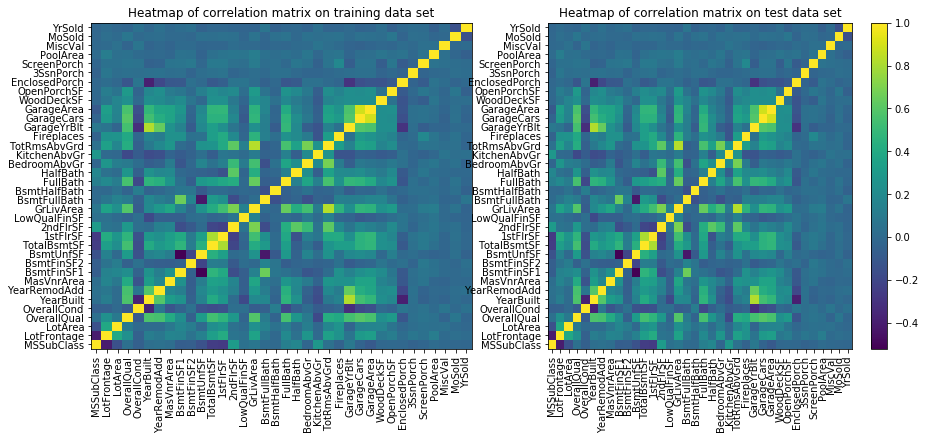

In [10]:
corr_test = numeric_test.corr()
corr_train = numeric.corr()

# Plot correlation map
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 6))

ax1.pcolor(corr_train)
ax1.set_xlim([0, 36])
ax1.set_ylim([0, 36])
ax1.set_xticks(np.arange(corr_train.shape[1]) + 0.5)
ax1.set_yticks(np.arange(corr_train.shape[1]) + 0.5)
ax1.set_xticklabels(numeric.columns.values, rotation=90)
ax1.set_yticklabels(numeric.columns.values)
ax1.set_title('Heatmap of correlation matrix on training data set')

ax2.pcolor(corr_test)
ax2.set_xlim([0, 36])
ax2.set_ylim([0, 36])
ax2.set_xticks(np.arange(corr_train.shape[1]) + 0.5)
ax2.set_yticks(np.arange(corr_train.shape[1]) + 0.5)
ax2.set_xticklabels(numeric.columns.values, rotation=90)
ax2.set_yticklabels(numeric.columns.values)
ax2.set_title('Heatmap of correlation matrix on test data set')

ax = plt.gca()
plt.colorbar(ax.pcolor(corr_train))
plt.show()

### Fill missing values with multi-linear regression

In [12]:
# Find and store indices for columns with no missing values or with missing values
no_missing_value_column_list = []
missing_value_column_list = []
for col in (discrete_col + continous_col):
    if sum(pd.isnull(df_all[col])) == 0:
        no_missing_value_column_list += [col]
    else:
        missing_value_column_list += [col]

# Array with no missing values for training dataset
array_full_values = df_all[no_missing_value_column_list]

# Store multiple linear regression models
line = []
index = 0
for i in missing_value_column_list:
    x_missing_value = array_full_values.loc[~pd.isnull(df_all[i])]
    y_missing_value = df_all.loc[~pd.isnull(df_all[i]), i]
    x_missing_train = array_full_values.loc[pd.isnull(df_all[i])]
    line += [Lin_Reg()]
    line[index].fit(x_missing_value, y_missing_value)
    df_all.loc[pd.isnull(df_all[i]), i] = line[index].predict(x_missing_train)
    index += 1
    df_all.loc[df_all[i] < 0, i] = 0

### B. Categorical Features

In [13]:
# Check for missing values
n_missing = [categorical_full[col].isnull().values.sum() for col in categorical_full]
missing = pd.DataFrame({'Features': categorical_full.columns.values, 'Missing': n_missing})
print('Number of missing values in training + test datasets:')
display(HTML(missing[missing['Missing'] != 0].to_html(index=False)))

Number of missing values in training + test datasets:


Features,Missing
Alley,2825
BldgType,1458
BsmtCond,1495
BsmtExposure,1496
BsmtFinType1,1495
BsmtFinType2,1496
BsmtQual,1495
CentralAir,1458
Condition1,1458
Condition2,1458


### Replacing 'NA' with 'Not Applicable'

For some categorical variables such as ‘Alley’ and ‘BsmtExposure’, **'NA'** as in **"Not Applicable"** *is* a valid category. We rename these categories as ‘Not Apply’, so that they won’t be confused with missing value ‘NA’.

In [14]:
# Replace NA with 'Not Apply' for columns which have NaN as a category
na_as_category = [
    'Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu',
    'GarageType','GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature',
]
for col in na_as_category:
    df_all.loc[df_all[col].isnull(), col] = 'Not Apply'

### Fill missing values with new category
We first attempted to fill in missing categorical data with the mode (most frequent), but this not ideal and may lead to high bias. For example, some houses may not have a garden, or an alley attached to them at all, but `garden` is the mode value of a particular variable.
Since the missing percentage for categotical features are very low (around 5%), we proceed to assume that a categorical feature is "not applicable" for observations with missing value.

After using 'Not Apply' instead of the mode, the performance of our models improved.

In [15]:
# Fill in missing values in categorical columns with a new category 'Not Apply'
for col in (ordinal_col + nominal_col):
    df_all.loc[pd.isnull(df_all[col]), col] = 'Not Apply'
    
# Check if all missing value are filled
n_missing=[]
for col in df_all:
    n_missing.append(df_all[col].isnull().values.sum())
missing = pd.DataFrame({'Features': df_all.columns.values, 'Missing': n_missing})
print('Number of missing values: {}'.format(missing[missing['Missing'] != 0].shape[0]))

Number of missing values: 0


### Encode categorical variable as dummy variables 

In [16]:
nominal = df_all[nominal_col]
ordinal = df_all[ordinal_col]
discrete = df_all[discrete_col]
continuous = df_all[continous_col]

temp_nominal = pd.get_dummies(nominal)
temp_ordinal = pd.get_dummies(ordinal)
result = pd.concat([discrete, continuous, temp_nominal, temp_ordinal], axis=1)

print('Without dummy variables: {}'.format(df_all.shape))
print('With dummy variables: {}'.format(result.shape))
display(HTML(result.head(n=5).to_html(index=False)))

Without dummy variables: (2917, 80)
With dummy variables: (2917, 310)


YearBuilt,YearRemodAdd,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,MoSold,YrSold,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MSSubClass,MSZoning_C (all),MSZoning_FV,MSZoning_Not Apply,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Not Apply,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Not Apply,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Not Apply,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Not Apply,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_N,CentralAir_Y,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_Not Apply,MiscFeature_Gar2,MiscFeature_Not Apply,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Not Apply,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,OverallQual,OverallCond,Utilities_AllPub,Utilities_NoSeWa,Utilities_Not Apply,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_Not Apply,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Not Apply,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_Not Apply,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Not Apply,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFi

## A First Look at Possible Important Features

Fit a simple linear model to each of the numeric feature on `SalePrice` to get a rough idea of which features are the strongest. We rank the features by R-squared value, and top 10 features are shown below:

In [18]:
y = df['SalePrice'].values
r_squared = []
pvalues = []
for i in range(36):
    model = OLS(y, numeric.iloc[:,i].values)
    results = model.fit()
    r_squared.append(results.rsquared)
    pvalues.append(results.pvalues)

t1 = df[['SalePrice', 'LotFrontage']].dropna()
model1 = OLS(t1['SalePrice'].values, t1['LotFrontage'].values)
r_squared1 = model1.fit().rsquared

t2 = df[['SalePrice', 'MasVnrArea']].dropna()
model2 = OLS(t2['SalePrice'].values, t2['MasVnrArea'].values)
r_squared2 = model2.fit().rsquared

t3 = df[['SalePrice', 'GarageYrBlt']].dropna()
model3 = OLS(t3['SalePrice'].values, t3['GarageYrBlt'].values)
r_squared3 = model3.fit().rsquared

xs = pd.DataFrame({'Features': numeric.columns.values, 'R-squared': r_squared})
xs.loc[xs['Features'] == 'LotFrontage', 'R-squared'] = r_squared1
xs.loc[xs['Features'] == 'MasVnrArea', 'R-squared'] = r_squared2
xs.loc[xs['Features'] == 'GarageYrBlt', 'R-squared'] = r_squared3
display(HTML(xs.sort_values(['R-squared'], ascending=False)[:10].to_html(index=False)))

Features,R-squared
OverallQual,0.928482
GrLivArea,0.925508
1stFlrSF,0.901342
TotalBsmtSF,0.898369
GarageCars,0.890540
TotRmsAbvGrd,0.884943
GarageArea,0.881416
FullBath,0.881229
GarageYrBlt,0.850565
YearBuilt,0.844005


#### `OverallQual`, `FullBath`, `1stFlrSf`, `TotRmAbvGrd`, `TotalBsmtSF`, `GarageCars`

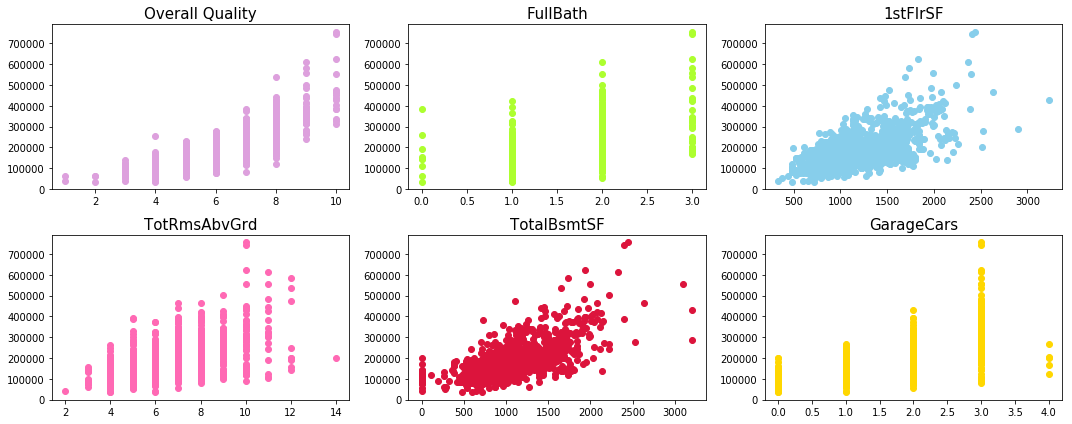

In [19]:
# SalePrice vs important features
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 6))

ax1.set_title('Overall Quality', fontsize=15)
ax1 = ax1.plot(numeric['OverallQual'].values, y, 'o', color='plum')

ax2.set_title('FullBath', fontsize=15)
ax2 = ax2.plot(numeric['FullBath'].values, y, 'o', color='greenyellow')

ax3.set_title('1stFlrSF', fontsize=15)
ax3 = ax3.plot(numeric['1stFlrSF'].values, y, 'o', color='skyblue')

ax4.set_title('TotRmsAbvGrd', fontsize=15)
ax4 = ax4.plot(numeric['TotRmsAbvGrd'].values, y, 'o', color='hotpink')

ax5.set_title('TotalBsmtSF', fontsize=15)
ax5 = ax5.plot(numeric['TotalBsmtSF'].values, y, 'o', color='crimson')

ax6.set_title('GarageCars', fontsize=15)
ax6 = ax6.plot(numeric['GarageCars'].values, y, 'o', color='gold')

plt.tight_layout()
plt.show()

As shown in the plots, **OverallQual, GrLivArea, 1stFlrSF, GarageCars, TotRmsAbvGrd, TotalBsmtSF, and GargeArea** all increase as sale price of the property increases. They are all positively related to sale price, and the relationships are roughly linear. We also notice that some of these predictors have discrete values and others are continuous. 

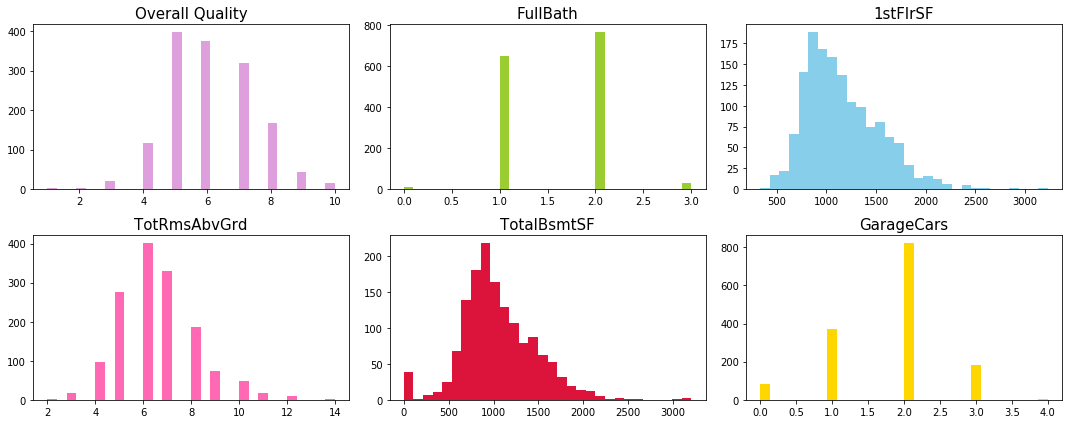

In [20]:
# Histograms
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 6))
ax1.set_title('Overall Quality', fontsize=15)
ax1 = ax1.hist(numeric['OverallQual'].values, color='plum', bins=30)

ax2.set_title('FullBath', fontsize=15)
ax2 = ax2.hist(numeric['FullBath'].values, color='yellowgreen', bins=30)

ax3.set_title('1stFlrSF', fontsize=15)
ax3 = ax3.hist(numeric['1stFlrSF'].values, color='skyblue', bins=30)

ax4.set_title('TotRmsAbvGrd', fontsize=15)
ax4 = ax4.hist(numeric['TotRmsAbvGrd'].values, color='hotpink', bins=30)

ax5.set_title('TotalBsmtSF', fontsize=15)
ax5 = ax5.hist(numeric['TotalBsmtSF'].values, color='crimson', bins=30)

ax6.set_title('GarageCars', fontsize=15)
ax6 = ax6.hist(numeric['GarageCars'].values, color='gold', bins=30)

plt.tight_layout()
plt.show()

As shown above, there's no extreme deviation of normal distribution for the distribution of `OverallQual`, `GrLivArea`, `1stFlrSF`, `GarageCars`, `TotRmsAbvGrd`, `TotalBsmtSF`, and `GargeArea`. The distribution of `GrLivArea` and `1stFlrSF` are slightly right-skewed.

## Feature Engineering
### A. Log Transformation on selected features
We also log transform some numerical features that has high skewness. Here are some examples:

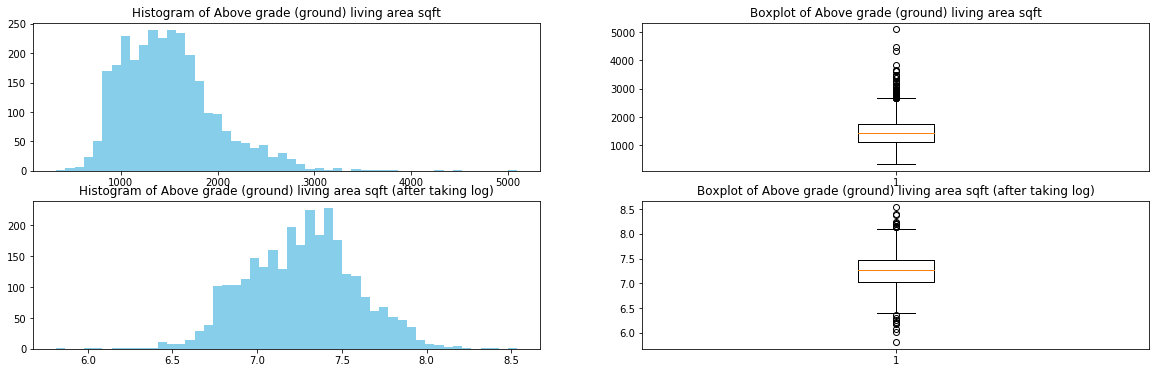

In [53]:
# Decrease skewness of numerical predictors which have a skewness value of more than 0.5
from scipy.stats import skew
skew_list_name = []
skew_list_val = []
for col in (discrete_col + continous_col):
    if skew(result[col]) > 0.5:
        skew_list_name += [col]
        skew_list_val += [skew(result[col])]
        result[col] = result[col].apply(np.log1p)
            
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 6))
ax1.hist(df_all['GrLivArea'], bins=50, color='skyblue')
ax1.set_title('Histogram of Above grade (ground) living area sqft')
ax2.boxplot(df_all['GrLivArea'])
ax2.set_title('Boxplot of Above grade (ground) living area sqft')

ax3.hist(result['GrLivArea'], bins=50, color='skyblue')
ax3.set_title('Histogram of Above grade (ground) living area sqft (after taking log)')
ax4.boxplot(result['GrLivArea'])
ax4.set_title('Boxplot of Above grade (ground) living area sqft (after taking log)')

plt.show()

### B. Adding quadratic and cubic terms
Some features have non-linear/curvilinear relationship with the target variable. Here we add in quadratic and cubic terms for some of them. 

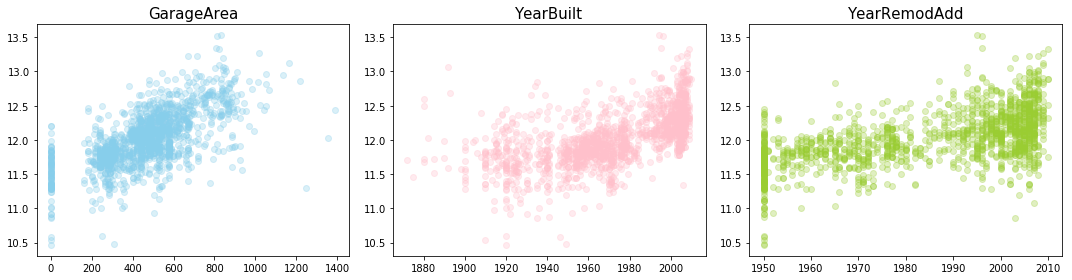

In [21]:
y = logprice.values
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title('GarageArea', fontsize=15)
ax1 = ax1.plot(df['GarageArea'].values, y, 'o', color='skyblue', alpha=0.3)

ax2.set_title('YearBuilt', fontsize=15)
ax2 = ax2.plot(df['YearBuilt'].values,y, 'o', color='pink', alpha=0.3)

ax3.set_title('YearRemodAdd', fontsize=15)
ax3 = ax3.plot(df['YearRemodAdd'].values, y, 'o', color='yellowgreen', alpha=0.3)

plt.tight_layout()
plt.show()

In [22]:
# Add quadratic and cubic terms to selected numerical predictors
top_ten = ['LotArea', 'TotalBsmtSF', 'YearBuilt', 'BsmtFinSF1', 'GarageCars', 'YearRemodAdd', 'GarageArea']
addon_numeric = []
for col in top_ten:
    new_name = 'quad_' + col
    addon_numeric += [new_name]
    result[new_name] = result[col] ** 2
    new_name = 'cubic_' + col
    addon_numeric += [new_name]
    result[new_name] = result[col] ** 3

### C. Standardization 

In [23]:
# Splitting back into train and test datasets
df_train = result[:train_count]
df_test = result[train_count:]

scalar_fit = StandardScaler().fit(result)
X_train = scalar_fit.transform(df_train)
X_test = scalar_fit.transform(df_test)

## Building Models

We build a number of models including:

1. LASSO Regression
2. Ridge Regression
3. Elastic Net
4. Extreme Gradient Boosting (XGBoosting)
5. Support Vector Machine Regressor (SVR)
6. Random Forest (RF)
7. Model Ensemble

The ensemble model showed the best performance, with the second best being LASSO. Below I use LASSO as an example.

### Define evaluation RMSE function 

In [24]:
def rmse_cv(model):
    return np.sqrt(-cross_val_score(model, X_train, y, scoring='neg_mean_squared_error', cv=10))

### Lasso Regression as an example

(The next two blocks take a while to execute)

In [26]:
# Using 10-fold cross validation to find optimal value of lambda
lambdas = np.linspace(-7, 7, 100)
cv_lasso = [rmse_cv(Lasso(alpha=10**i)).mean() for i in lambdas]

In [27]:
# Finding the best lambda with greater precision near the minimum 
min_value = min(cv_lasso)
min_index = cv_lasso.index(min_value)
best_value = lambdas[min_index]
lambdas = np.linspace(best_value - 0.3 , best_value + 0.3, 100)
cv_lasso_precise = [rmse_cv(Lasso(alpha=10**i)).mean() for i in lambdas]

Lasso Regression min RMSE on training set: 0.109782912824


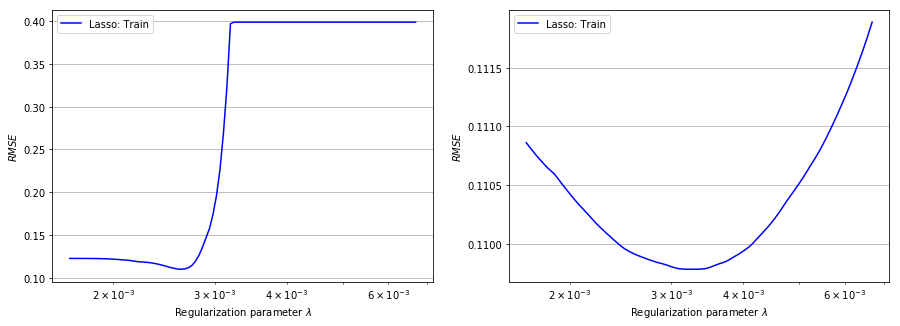

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.semilogx(10.0**lambdas, (cv_lasso), c='b', label='Lasso: Train')
ax1.set_xlabel('Regularization parameter $\lambda$')
ax1.set_ylabel(r'$RMSE$')
ax1.grid()
ax1.legend(loc = 'best')

ax2.semilogx(10.0**lambdas, (cv_lasso_precise), c='b', label='Lasso: Train')
ax2.set_xlabel('Regularization parameter $\lambda$')
ax2.set_ylabel(r'$RMSE$')
ax2.grid()
ax2.legend(loc = 'best')

print('Lasso Regression min RMSE on training set: {}'.format(min(cv_lasso_precise)))

In [29]:
min_value = min(cv_lasso_precise)
min_index = cv_lasso_precise.index(min_value)
best_lasso = Lasso(alpha=10**(lambdas[min_index])).fit(X_train, y)

print('Lambda for min RMSE: {}'.format(lambdas[min_index]))
print('Min RMSE for Lasso Model: {}'.format(rmse_cv(best_lasso).mean()))
coef = pd.Series(best_lasso.coef_, index=result.columns)
print('Lasso picked {} variables and eliminated the other {} variables'.format(sum(coef != 0), sum(coef == 0)))

Lambda for min RMSE: -2.4898989899
Min RMSE for Lasso Model: 0.109782912824
Lasso picked 124 variables and eliminated the other 200 variables


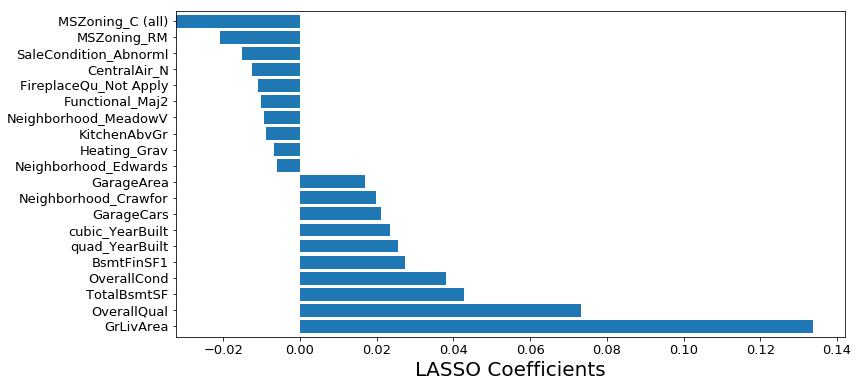

In [30]:
# Feature importance (top and bottom 10s)
newcoef = coef[coef != 0]
newcoef = pd.DataFrame(newcoef)
newcoef_sorted = newcoef.sort_values(by=[0], ascending=[False])
imp_coef = pd.concat([newcoef_sorted.head(10), newcoef_sorted.tail(10)])
matplotlib.rcParams['figure.figsize'] = (12, 6)
imp_coef.plot(kind='barh', width=0.8, legend=None, fontsize=13)
plt.xlabel('LASSO Coefficients', fontsize=20)
plt.show()

In [31]:
# Prediction on test dataset
y_pred = best_lasso.predict(X_test)
y_pred_mlr = 2.71828 ** y_pred
result_predict = pd.DataFrame({'Id': id_test.values, 'SalePrice': y_pred_mlr})
result_predict.to_csv('LASSO.csv', header=True, index=False)